### Student Information
Name: Gerraldo SC 鄭嘉成

Student ID: 108006218

GitHub ID: Lewisu

Kaggle name: Lewis SC

Kaggle private scoreboard snapshot:
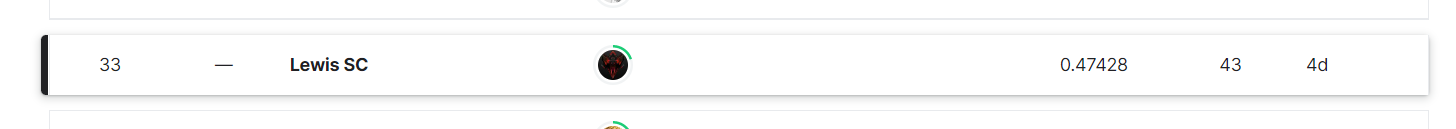


---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2022-Lab2-master Repo](https://github.com/keziatamus/DM2022-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/2b0d14a829f340bc88d2660dc602d4bd. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Nov. 22th 11:59 pm, Tuesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 25th 11:59 pm, Friday)__. 

In [1]:
### Begin Assignment Here
import pandas as pd
import seaborn as sns
import gensim
import itertools
import warnings
import ssl
import string
import re
import urllib.request
import math
import tensorflow as tf
import scipy

import nltk
from nltk.tokenize import TweetTokenizer

import numpy as np
from numpy import arange

import plotly as py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger
%matplotlib inline

In [3]:
### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


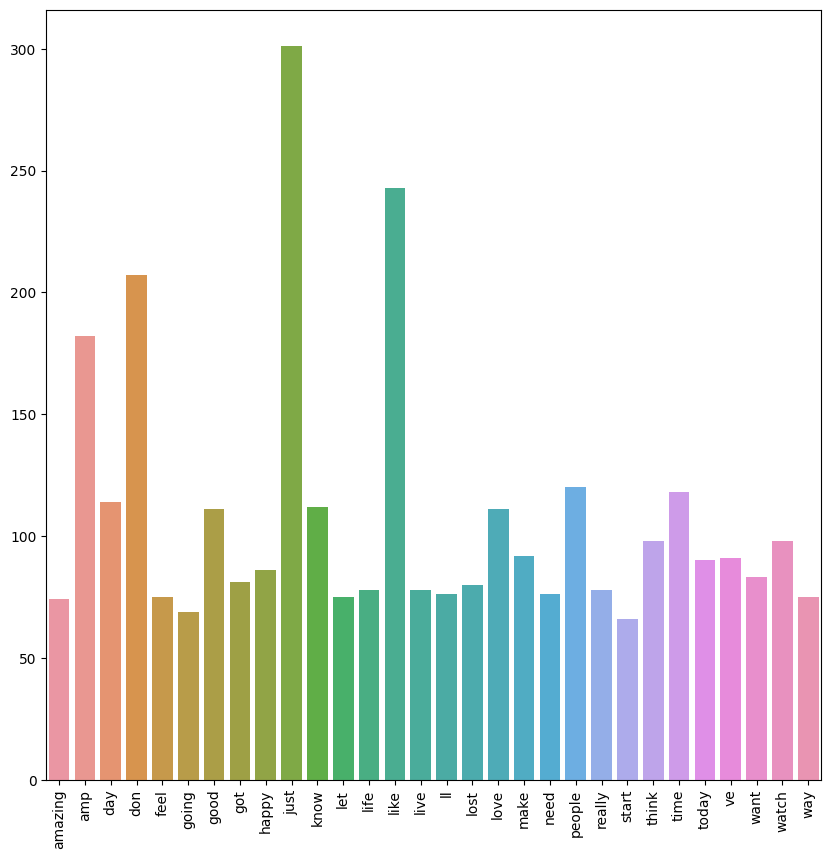

In [4]:
vectorizer = CountVectorizer(max_features = 30, stop_words = "english")
train_counts = vectorizer.fit_transform(train_df["text"])

# First 30 features graph for train dataset
term_frequencies = []
for j in range(0, train_counts.shape[1]):
    term_frequencies.append(sum(train_counts[:,j].toarray()))
    
term_frequencies = np.asarray(train_counts.sum(axis=0))[0]

plt.subplots(figsize=(10, 10))
g = sns.barplot(x=vectorizer.get_feature_names_out(), 
            y=term_frequencies)
g.set_xticklabels(vectorizer.get_feature_names_out(), rotation = 90);

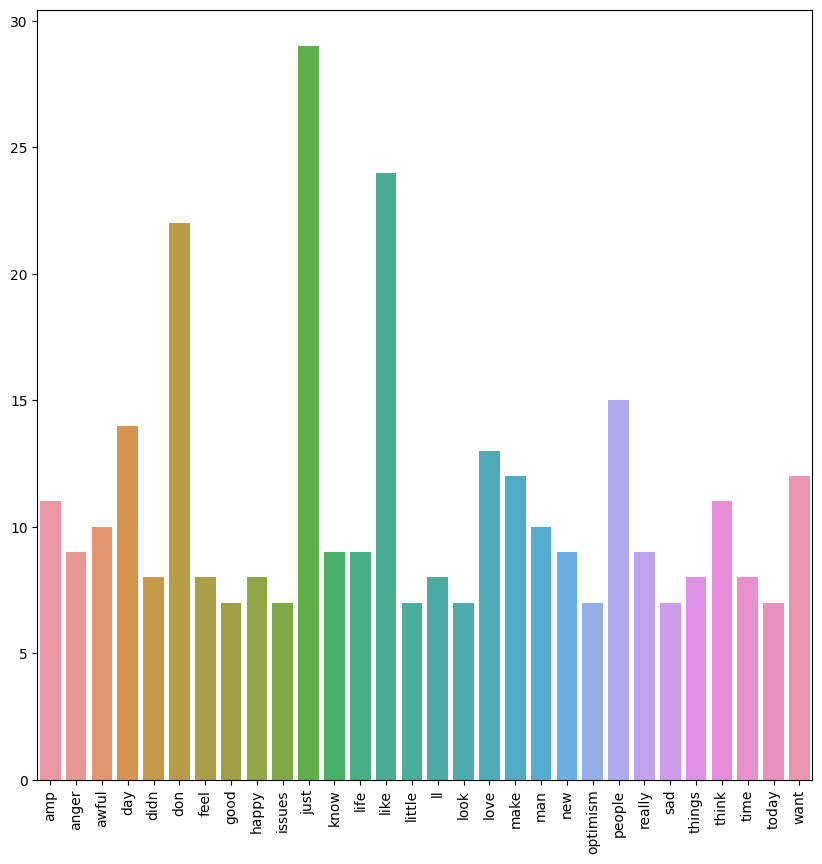

In [5]:
test_counts = vectorizer.fit_transform(test_df["text"])

# First 30 features graph for test dataset
term_frequencies = []
for j in range(0, test_counts.shape[1]):
    term_frequencies.append(sum(test_counts[:,j].toarray()))
    
term_frequencies = np.asarray(test_counts.sum(axis=0))[0]

plt.subplots(figsize=(10, 10))
g = sns.barplot(x=vectorizer.get_feature_names_out(), 
            y=term_frequencies)
g.set_xticklabels(vectorizer.get_feature_names_out(), rotation = 90);

### ** >>> End of Exercise 1**  

In [6]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

In [7]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

In [8]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

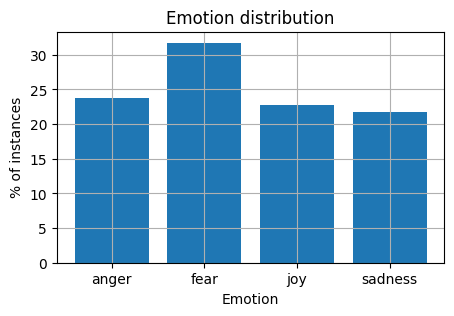

In [9]:
# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [10]:
# tf idf vectorizer
tfidfvect = TfidfVectorizer(max_features = 1000, stop_words = 'english')
tfidf_counts = tfidfvect.fit_transform(train_df["text"])
# observe some feature names
features_1000 = tfidfvect.get_feature_names_out()
features_1000[100:110]


array(['blue', 'blues', 'body', 'boiling', 'book', 'boss', 'bought',
       'bout', 'boy', 'break'], dtype=object)

### ** >>> End of Exercise 2**  

In [11]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = tfidfvect.transform(train_df['text'])
y_train = train_df['emotion']

X_test = tfidfvect.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 1000)
y_train.shape:  (3613,)
X_test.shape:  (347, 1000)
y_test.shape:  (347,)


In [12]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'anger', 'fear', 'sadness', 'sadness', 'joy', 'fear', 'joy',
       'fear', 'sadness'], dtype=object)

In [13]:
## accuracy
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


training accuracy: 0.98
testing accuracy: 0.77


In [14]:
## precision, recall, f1-score
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.77      0.77      0.77        84
        fear       0.75      0.80      0.77       110
         joy       0.83      0.81      0.82        79
     sadness       0.75      0.69      0.72        74

    accuracy                           0.77       347
   macro avg       0.78      0.77      0.77       347
weighted avg       0.77      0.77      0.77       347



In [15]:
## check by confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[65  9  4  6]
 [ 8 88  5  9]
 [ 4  9 64  2]
 [ 7 12  4 51]]


In [16]:
# Function for visualizing confusion_matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

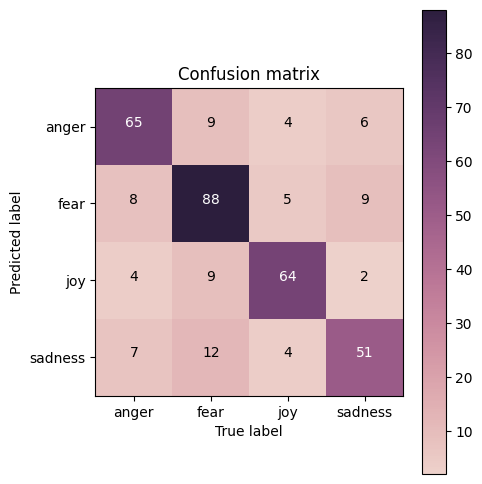

In [17]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

It creates a table in which we see the predicted label and the supposed label of the data. For example, there's 65 + 9 + 4 + 6 datas are predicted as anger, but only 65 of them are indeed anger, while 9 of them are fear, 4 of them joy, and 6 of them sadness. The same method is used to read the other data.

### ** >>> End of Exercise 3**  

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [21]:
# Naive Bayes Model
model = make_pipeline(tfidfvect, MultinomialNB(alpha = 1))
model.fit(train_df["text"], train_df["emotion"])
label = model.predict(test_df['text'])
model.score(train_df["text"], train_df["emotion"])

0.8923332410738998

In [22]:
## check by confusion matrix
cm = confusion_matrix(y_true=test_df["emotion"], y_pred=label) 
print(cm)

[[61 14  3  6]
 [ 5 94  5  6]
 [ 2  9 65  3]
 [ 1 13  3 57]]


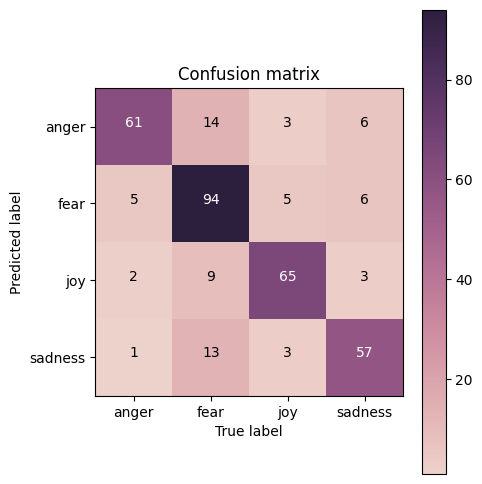

In [23]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

### ** >>> End of Exercise 4**  

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

It seems that DT model have higher result for anger, while NB model have better result for the other emotions. I think this happens because in DT model it branches a lot more to anger because it decides that its features fit the pattern for anger label, and the pattern for anger might have a lot of similarities with other label but the model already decides that it suits anger label more than other label, while actually its not

### ** >>> End of Exercise 5**  

In [27]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 2738        joy
1849       fear
1578       fear
3092    sadness
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


C:\Users\Lewis\AppData\Local\Temp\ipykernel_12260\2157002640.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print('y_train[0:4]:\n', y_train[0:4])


In [28]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  1000
output_shape:  4


In [30]:
# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 softmax (Softmax)           (None, 4)                 0     

In [34]:
csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25


D:\Anaconda\envs\dmenv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


113/113 [==============================] - 3s 4ms/step - loss: 1.3181 - accuracy: 0.3626 - val_loss: 1.1440 - val_accuracy: 0.5908
Epoch 2/25
113/113 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.8021 - val_loss: 0.5380 - val_accuracy: 0.8127
Epoch 3/25
113/113 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.8970 - val_loss: 0.5345 - val_accuracy: 0.8127
Epoch 4/25
113/113 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.9322 - val_loss: 0.5750 - val_accuracy: 0.7954
Epoch 5/25
113/113 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9466 - val_loss: 0.6229 - val_accuracy: 0.7925
Epoch 6/25
113/113 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.9529 - val_loss: 0.6660 - val_accuracy: 0.7896
Epoch 7/25
113/113 [==============================] - 0s 2ms/step - loss: 0.1141 - accuracy: 0.9552 - val_loss: 0.7220 - val_accuracy: 0.7695
Epoch 8/25
113/11

In [35]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3/3 [==============================] - 0s 2ms/step


array([[2.2888562e-05, 1.1722508e-05, 9.9952924e-01, 4.3622221e-04],
       [9.9999452e-01, 7.0029233e-07, 9.9162389e-07, 3.8498861e-06],
       [1.3637140e-02, 9.8382521e-01, 1.3485489e-03, 1.1891167e-03],
       [1.1830094e-05, 4.7804287e-01, 6.7196321e-05, 5.2187818e-01],
       [3.4888522e-04, 9.4912887e-01, 9.5073221e-05, 5.0427109e-02]],
      dtype=float32)

In [36]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['joy', 'anger', 'fear', 'sadness', 'fear'], dtype=object)

In [38]:
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.76


In [22]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.362580,1.318098,0.590778,1.143957
1,1,0.802104,0.668315,0.812680,0.537985
2,2,0.897038,0.301346,0.812680,0.534459
3,3,0.932189,0.204970,0.795389,0.575014
4,4,0.946582,0.159264,0.792507,0.622874
5,5,0.952948,0.132357,0.789625,0.665989
6,6,0.955162,0.114143,0.769452,0.721971
7,7,0.961251,0.099735,0.775216,0.764389
8,8,0.962912,0.091403,0.780980,0.809570
9,9,0.962912,0.086081,0.772334,0.838491


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?

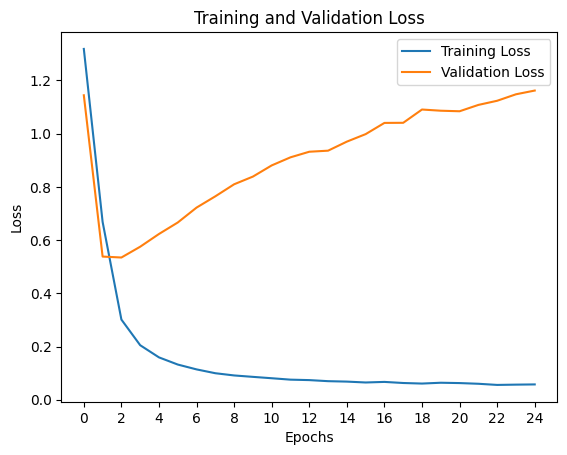

In [43]:
# Generate a sequence of integers to represent the epoch numbers
ranges = range(0, epochs)
 
# Plot and label the training and validation loss values
plt.plot(ranges, training_log.loss, label='Training Loss')
plt.plot(ranges, training_log.val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, epochs, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

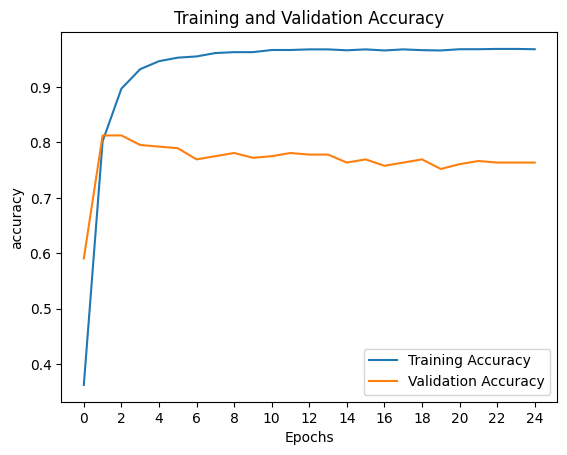

In [26]:
# Generate a sequence of integers to represent the epoch numbers
ranges = range(0, epochs)
 
# Plot and label the training and validation accuracy values
plt.plot(ranges, training_log.accuracy, label='Training Accuracy')
plt.plot(ranges, training_log.val_accuracy, label='Validation Accuracy')
 
# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
 
# Set the tick locations
plt.xticks(arange(0, epochs, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

The result of the plot shows that our model is overfitted. Since the validation loss is way higher than training loss.

### ** >>> End of Exercise 6**  

In [44]:
warnings.filterwarnings('ignore')
# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
2738,30734,When your rewatching glee and break down in te...,"[When, your, rewatching, glee, and, break, dow..."
1849,20992,@darwinwatersons @pennyfitzger31 @gumballwatte...,"[@, darwinwatersons, @, pennyfitzger31, @, gum..."
1578,20721,@rkuuleiq Fear is best/beast product of God/s....,"[@, rkuuleiq, Fear, is, best/beast, product, o..."
3092,40265,she's always so insensitive whenever i grieve ...,"[she, 's, always, so, insensitive, whenever, i..."
1971,21114,It's so funny cause Cooper's going to go farth...,"[It, 's, so, funny, cause, Cooper, 's, going, ..."


In [45]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['When', 'your', 'rewatching', 'glee', 'and', 'break', 'down', 'in', 'tears', 'all', 'over', 'again', '.', '😭😢']),
       list(['@', 'darwinwatersons', '@', 'pennyfitzger31', '@', 'gumballwatter15', 'ok', 'but', 'why', 'tomorrow', 'a', 'horrible', 'day', ',', 'my', 'day', 'was', 'great', '!']),
       list(['@', 'rkuuleiq', 'Fear', 'is', 'best/beast', 'product', 'of', 'God/s', '.', ':', ')', '#', 'aTheism', '#', 'theism', '#', 'biBle', '#', 'afraid', '#', 'christianity', '#', 'hell', '#', 'heaven', '#', 'purgatory', '#', 'psychology', '#', 'jesus'])],
      dtype=object)

In [46]:
## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)

In [47]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.45459694,  0.59295624, -0.00866727, -0.27129304, -0.18155505,
       -1.2812133 ,  0.626594  ,  1.3246294 , -0.45488083, -0.49834612,
       -0.62916577, -0.7599758 , -0.42929155,  0.8650871 , -0.19340475,
       -0.75295573, -0.19077526, -0.40671062,  0.04734985, -0.78625196,
        0.6312963 ,  0.7941094 ,  0.87784755,  0.40660554,  0.47162428,
        0.06078382, -0.43487674,  0.516188  , -0.1367038 ,  0.16507456,
        0.6133132 , -0.18161584,  0.2821889 , -0.9956011 , -0.33438772,
        0.32763165,  0.1831126 ,  0.08563395, -0.16420206, -0.27952045,
       -0.16268823,  0.08584247, -0.5169541 ,  0.4555922 ,  0.36494613,
        0.15468015, -1.182038  ,  0.36741278,  0.12800178,  0.42426977,
       -0.46911988, -0.33758685, -0.06146546, -0.44390354, -0.49276608,
       -0.4184002 ,  0.3273705 ,  0.04554695, -0.19538103,  0.32099417,
        0.1403508 , -0.27074108,  0.4682311 ,  0.20061672, -0.5797476 ,
        0.9027843 ,  0.5785867 ,  0.6086514 , -1.3439739 ,  0.38

In [48]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[("'you", 0.9279083013534546),
 ('Be', 0.921039342880249),
 ('birthday', 0.9143928289413452),
 ('smile', 0.9109486937522888),
 ('help', 0.9057348966598511),
 ('cry', 0.9033940434455872),
 ('play', 0.9017891883850098),
 ('🕋', 0.9012281894683838),
 ('free', 0.896955132484436),
 ('bday', 0.896641194820404)]

In [50]:
## Note: this model is very huge, this will take some time ...
model_path = "GoogleNews-vectors-negative300.bin.gz"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [52]:
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

[==================================================] 100.0% 104.8/104.8MB downloaded
load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158351421356201),
 ('thanks', 0.915008544921875),
 ('merry', 0.9053249359130859),
 ('bless', 0.902732253074646),
 ('wish', 0.9013164043426514)]

In [53]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


By tokenizing the sentence first then I'm thinking to use the words within the sentence that has the highest similarities with one of the emotions and pick it as the representative of the sentence.

### ** >>> End of Exercise 7** 

In [54]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [56]:
# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 1
word: fear 	 cluster: 1
word: angry 	 cluster: 1
word: car 	 cluster: 0
word: teacher 	 cluster: 0
word: computer 	 cluster: 0


In [57]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0])

In [58]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1])

In [59]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


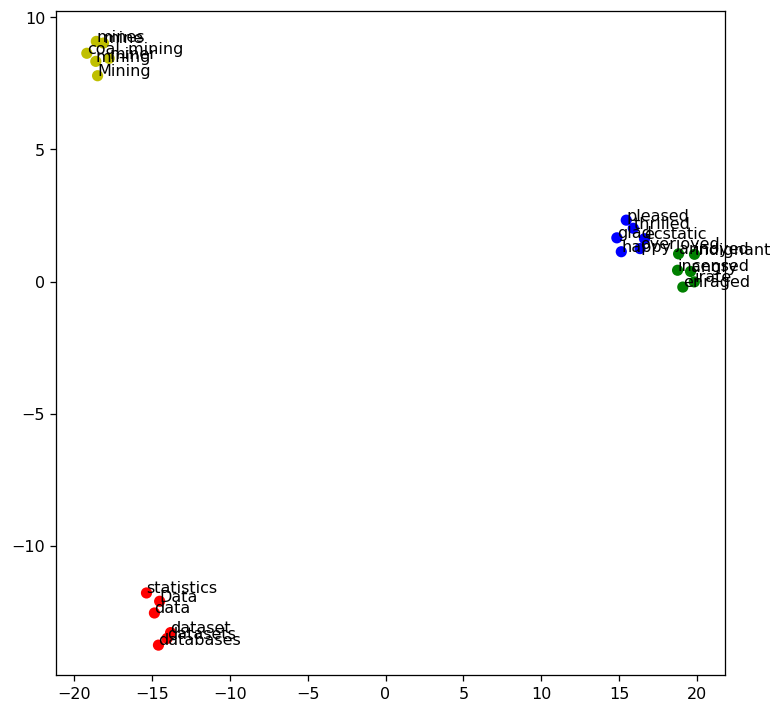

In [61]:
## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [62]:
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = happy_words + angry_words + sad_words +fear_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
sad_words:  ['sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirsc

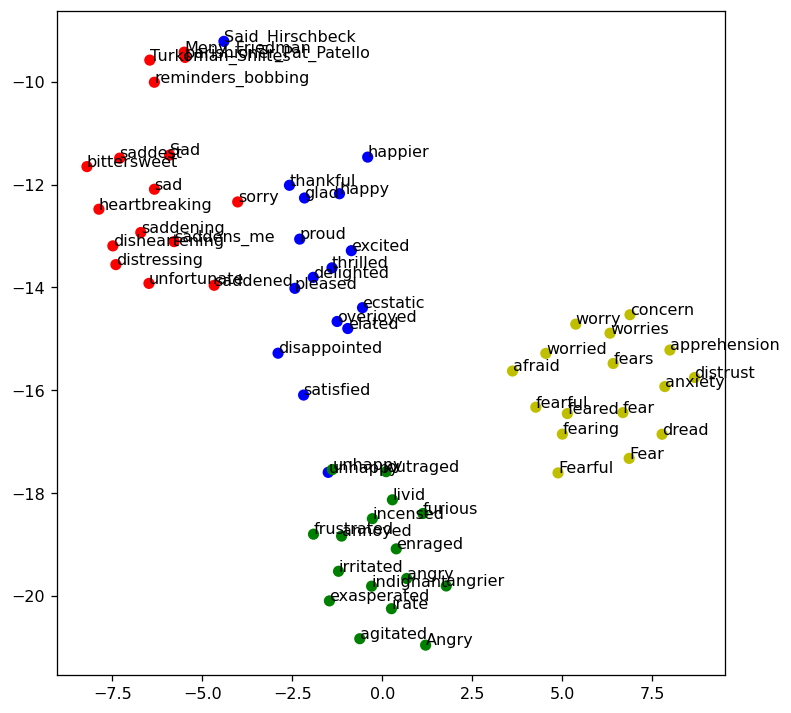

In [66]:
## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

### ** >>> End of Exercise 8**  

### ** >>> Kaggle**  

In [2]:
# Load .Json to pandas dataframe
twitter_df = pd.read_json(r'twitter\tweets_DM.json', lines = True)
twitter_df

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets
...,...,...,...,...,...
1867530,827,hashtag_tweets,"{'tweet': {'hashtags': ['mixedfeeling', 'butim...",2015-05-12 12:51:52,tweets
1867531,368,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x29d0...",2017-10-02 17:54:04,tweets
1867532,498,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2a6a...",2016-10-10 11:04:32,tweets
1867533,840,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x24fa...",2016-09-02 14:25:06,tweets


In [3]:
twitter_df = pd.DataFrame(twitter_df._source.values.tolist())
twitter_df = pd.DataFrame(twitter_df.tweet.values.tolist())

In [4]:
twitter_df = twitter_df.drop("hashtags", axis = 1)
twitter_df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [5]:
# Sort by tweet_id
twitter_df = twitter_df.sort_values("tweet_id", ignore_index = True)
twitter_df

,tweet_id,text
0,0x1c7f0f,"@JZED74 While inappropriate AF, he likely wasn..."
1,0x1c7f10,o m g Shut Up And Dance though #BlackMirror <LH>
2,0x1c7f11,On #twitch <LH> on the #Destinybeta #Destiny #...
3,0x1c7f12,I tried to figure out why you mean so much to ...
4,0x1c7f13,"The only “big plan” you ever had in your life,..."
...,...,...
1867530,0x38fe19,Where is #WesHoolahan?! #WALvIRL #COYBIG <LH>
1867531,0x38fe1a,@mattmfm Fake news! <LH> propagated by Tumpkin...
1867532,0x38fe1b,I told myself I'd be twitter famous. twitter m...
1867533,0x38fe1c,..today was brutal ..#Hungover


In [2]:
# Load classifier and emotion
classifier_df = pd.read_csv(r'twitter\data_identification.csv')
emotion_df = pd.read_csv(r'twitter\emotion.csv')

In [3]:
# Sort by tweet_id
classifier_df = classifier_df.sort_values("tweet_id", ignore_index = True)
classifier_df

,tweet_id,identification
0,0x1c7f0f,test
1,0x1c7f10,train
2,0x1c7f11,train
3,0x1c7f12,test
4,0x1c7f13,test
...,...,...
1867530,0x38fe19,train
1867531,0x38fe1a,train
1867532,0x38fe1b,test
1867533,0x38fe1c,train


In [ ]:
# Add identificaiton column
twitter_df = twitter_df.join(classifier_df.identification)
twitter_df

In [9]:
# Save to pickle
twitter_df.to_pickle("twitter_df.pkl") 

In [3]:
# Load from pickle
twitter_df = pd.read_pickle("twitter_df.pkl")

For the preprocessing I tried to remove the twitter mentions, hashtags, <LH>, numbers, and some punctuations. I also make all of the words into lowercase. I also tried to decontract some words. But somehow the result of using uncleaned data (Using the data directly after reading it from json and taking the preferred info) gives a better result. I tried to only remove the twitter mentions and <LH> but the uncleaned data still gives better result, it seems like cleaning just make it worse but I don't fully understand why in these cases.

In [4]:
def remove_pattern(input_txt, pattern, sub):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, sub, input_txt)
        
    return input_txt

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
# Decontract words
twitter_df["text"] = twitter_df["text"].apply(lambda x: decontracted(x))

In [6]:
# Remove Mentions
twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], "@[\w]*", "")
# Remove <LH>
twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'<LH>', "")
# # Remove Punctuations
# twitter_df["text"] = twitter_df["text"].str.replace("[^a-zA-Z]", " ")
# twitter_df["text"] = twitter_df["text"].str.replace("[^a-zA-Z#]", " ")
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r':', "")
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'!', "")
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], '\"', "")
# Remove Hashtags
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'#[\w]*', "")
twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'#', "")
# Remove Numbers
twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'[0-9]', "")
# Remove RTs
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'^RT[\s]+', "")
# # remove all single characters
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'\s+[a-zA-Z]\s+', " ")
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'\s+[a-zA-Z]\s+', " ")
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'\s+[a-zA-Z]\s+', " ")
# # Remove single characters from the start
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'\^[a-zA-Z]\s+', " ")
# Substituting multiple spaces with single space
# twitter_df["text"] = np.vectorize(remove_pattern)(twitter_df["text"], r'\s+', " ")
# Lowercase every words
twitter_df["text"] = twitter_df["text"].apply(lambda x: x.lower())

In [7]:
twitter_df

,tweet_id,text,identification
0,0x1c7f0f,"while inappropriate af, he likely was not kid...",test
1,0x1c7f10,o m g shut up and dance though blackmirror,train
2,0x1c7f11,on twitch on the destinybeta destiny destiny ...,train
3,0x1c7f12,i tried to figure out why you mean so much to ...,test
4,0x1c7f13,"the only “big plan” you ever had in your life,...",test
...,...,...,...
1867530,0x38fe19,where is weshoolahan?! walvirl coybig,train
1867531,0x38fe1a,fake news! propagated by tumpkins. not maga,train
1867532,0x38fe1b,i told myself i would be twitter famous. twitt...,test
1867533,0x38fe1c,..today was brutal ..hungover,train


In [8]:
twitter_df["text"][1867534]

'love it when i sun burn my forehead!! not!! 😫😱🙄🤦🏼\u200d♀️☀️ redheadproblems  ouch burnt'

In [79]:
# Save to pickle
twitter_df.to_pickle("twitter_df2.pkl") 

In [3]:
# Load from pickle
twitter_df = pd.read_pickle("twitter_df2.pkl")

In [9]:
# Split into train and test dataframe
train_twitter = pd.DataFrame(twitter_df[twitter_df.identification == "train"])
test_twitter = pd.DataFrame(twitter_df[twitter_df.identification == "test"])

In [10]:
# Reindex by sorting
train_twitter = train_twitter.sort_values("tweet_id", ignore_index = True)
train_twitter

,tweet_id,text,identification
0,0x1c7f10,o m g shut up and dance though blackmirror,train
1,0x1c7f11,on twitch on the destinybeta destiny destiny ...,train
2,0x1c7f14,"a nice sunny wak this morning not many aroud,...",train
3,0x1c7f15,i am one of those people who love candy corn.....,train
4,0x1c7f16,what are these? they look like something todd...,train
...,...,...,...
1455558,0x38fe18,um my vote for for song of the summer,train
1455559,0x38fe19,where is weshoolahan?! walvirl coybig,train
1455560,0x38fe1a,fake news! propagated by tumpkins. not maga,train
1455561,0x38fe1c,..today was brutal ..hungover,train


In [11]:
# Reindex by sorting
test_twitter = test_twitter.sort_values("tweet_id", ignore_index = True)
test_twitter

,tweet_id,text,identification
0,0x1c7f0f,"while inappropriate af, he likely was not kid...",test
1,0x1c7f12,i tried to figure out why you mean so much to ...,test
2,0x1c7f13,"the only “big plan” you ever had in your life,...",test
3,0x1c7f17,"looking back on situations old & new, recent o...",test
4,0x1c7f18,why do you insist on talking about the clinto...,test
...,...,...,...
411967,0x38fe04,"""the grand bargain"" the great american betraya...",test
411968,0x38fe06,i get to be a year old girl is new mama start...,test
411969,0x38fe13,asian dude with dangly gold earrings is back &...,test
411970,0x38fe14,i think might be the worst player in the rig...,test


In [12]:
# Sort by tweet_id
emotion_df = emotion_df.sort_values("tweet_id", ignore_index = True)
emotion_df

,tweet_id,emotion
0,0x1c7f10,joy
1,0x1c7f11,anticipation
2,0x1c7f14,joy
3,0x1c7f15,joy
4,0x1c7f16,disgust
...,...,...
1455558,0x38fe18,sadness
1455559,0x38fe19,anticipation
1455560,0x38fe1a,surprise
1455561,0x38fe1c,disgust


In [13]:
# Insert the emotion data
train_twitter = train_twitter.join(emotion_df.emotion)
train_twitter

,tweet_id,text,identification,emotion
0,0x1c7f10,o m g shut up and dance though blackmirror,train,joy
1,0x1c7f11,on twitch on the destinybeta destiny destiny ...,train,anticipation
2,0x1c7f14,"a nice sunny wak this morning not many aroud,...",train,joy
3,0x1c7f15,i am one of those people who love candy corn.....,train,joy
4,0x1c7f16,what are these? they look like something todd...,train,disgust
...,...,...,...,...
1455558,0x38fe18,um my vote for for song of the summer,train,sadness
1455559,0x38fe19,where is weshoolahan?! walvirl coybig,train,anticipation
1455560,0x38fe1a,fake news! propagated by tumpkins. not maga,train,surprise
1455561,0x38fe1c,..today was brutal ..hungover,train,disgust


At some point I thought that the unequal distribution of the data for each emotions might be the problem with my low accuracy result. But after I tried making it equally distributed (39000 datas for each emotion since anger has the lowest data of around 39000 datas) the result isn't as good as using all data.

In [14]:
my_tags = ['anger', 'anticipation', 'disgust', 'fear', 'sadness', 'surprise', 'trust', 'joy']
train_subset = pd.DataFrame(columns = ["tweet_id", "text", "identification", "emotion"])
# Make every emotion have same number of data
for emotion in my_tags:
    train_subset = pd.concat([train_subset, train_twitter[train_twitter["emotion"] == emotion].sample(n = 39000)], ignore_index = True)
train_subset

,tweet_id,text,identification,emotion
0,0x1e5de3,your south side bloomington pharmacy sucks! i...,train,anger
1,0x1ec49d,"🕘 : oct 🇺🇸usd = , 🇪🇺eur = , 🇨🇦cad = , 🇬🇧gbp ...",train,anger
2,0x1cd4d1,trying to deal with social security over a dea...,train,anger
3,0x2718d5,"🕘 : aug 🇺🇸usd = , 🇪🇺eur = , 🇨🇦cad = , 🇬🇧gbp ...",train,anger
4,0x2fee4c,whats the point in farming an event if u get ...,train,anger
...,...,...,...,...
311995,0x2ad0cd,charity_makes_me_sad_coz :tell me in reality t...,train,joy
311996,0x29e070,"each twitter in my ecosystem has a different ""...",train,joy
311997,0x1f3f5b,babnla daddyo chief only you international o...,train,joy
311998,0x1d10ca,this morning i was laying with and talking to ...,train,joy


In [15]:
# Shuffle 4 times
train_subset = train_subset.sample(frac = 1.0, ignore_index = True)
train_subset = train_subset.sample(frac = 1.0, ignore_index = True)
train_subset = train_subset.sample(frac = 1.0, ignore_index = True)
train_subset = train_subset.sample(frac = 1.0, ignore_index = True)
train_subset

,tweet_id,text,identification,emotion
0,0x36ea7f,still strong and will neva fall.... riche...,train,disgust
1,0x3125c3,wum - everton fan as a kid and liverpool legend,train,sadness
2,0x365df5,"on googlemaps, every single face of colonel sa...",train,surprise
3,0x3389d9,more days 🙅🏽😝,train,anticipation
4,0x380339,i love my job 💁🏻,train,joy
...,...,...,...,...
311995,0x241057,steve had a whole greggs cake and i almost cri...,train,trust
311996,0x30a677,"if you are going through hell, keep going. ~ w...",train,trust
311997,0x1ee706,europe spain is your,train,disgust
311998,0x26af6b,matter of days till end of month. can’t wait s...,train,anticipation


In [14]:
# Shuffle 4 times
train_twitter = train_twitter.sample(frac = 1.0, ignore_index = True)
train_twitter = train_twitter.sample(frac = 1.0, ignore_index = True)
train_twitter = train_twitter.sample(frac = 1.0, ignore_index = True)
train_twitter = train_twitter.sample(frac = 1.0, ignore_index = True)
train_twitter

,tweet_id,text,identification,emotion
0,0x301023,"., specialist producers of clean, biltong, as...",train,trust
1,0x2c7735,shout out to for the hospitality this past we...,train,joy
2,0x26305e,trump on nfl we are on to yourhonor changing ...,train,trust
3,0x2683f4,"by god, and afflicted. but he was wounded fo...",train,anticipation
4,0x38fa3d,today at work a camper said i looked like prin...,train,joy
...,...,...,...,...
1455558,0x344a26,and not a single person believes him. 🤦‍♂️,train,sadness
1455559,0x2c4b59,sad to see body shaming another female. thos...,train,disgust
1455560,0x2cbfed,chelsea with an unfair advantage but i hope th...,train,anticipation
1455561,0x33a679,considering he is going to do everything poss...,train,sadness


In [17]:
train_twitter = pd.DataFrame(train_subset)
train_twitter

,tweet_id,text,identification,emotion
0,0x36ea7f,still strong and will neva fall.... riche...,train,disgust
1,0x3125c3,wum - everton fan as a kid and liverpool legend,train,sadness
2,0x365df5,"on googlemaps, every single face of colonel sa...",train,surprise
3,0x3389d9,more days 🙅🏽😝,train,anticipation
4,0x380339,i love my job 💁🏻,train,joy
...,...,...,...,...
311995,0x241057,steve had a whole greggs cake and i almost cri...,train,trust
311996,0x30a677,"if you are going through hell, keep going. ~ w...",train,trust
311997,0x1ee706,europe spain is your,train,disgust
311998,0x26af6b,matter of days till end of month. can’t wait s...,train,anticipation


In [15]:
# Twitter tokenizer
def tok(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

The first model that I tried to use is multinomialNB with tfidf vectorizer. It yields a pretty decent result but not high enough. I was not sure how to tune my parameters (mid_df, max_df, ngram, and the tokenizer) which might lead to a not so good result

In [16]:
# tf idf vectorizer
tfidfvect = TfidfVectorizer(ngram_range=(1,1), min_df = 5, max_df = 0.8, tokenizer=tok)
tfidf_counts = tfidfvect.fit_transform(train_twitter["text"])

# Naive Bayes Model
model = make_pipeline(tfidfvect, MultinomialNB(alpha = 1))
model.fit(train_twitter["text"], train_twitter["emotion"])
label = model.predict(test_twitter['text'])
model.score(train_twitter["text"], train_twitter["emotion"])

0.5398502160332462

In [17]:
prediction_df = pd.DataFrame()
prediction_df["id"] = test_twitter.tweet_id
prediction_df["emotion"] = label
prediction_df.to_csv('test.csv', index = False)
prediction_df

,id,emotion
0,0x1c7f0f,sadness
1,0x1c7f12,sadness
2,0x1c7f13,anticipation
3,0x1c7f17,joy
4,0x1c7f18,sadness
...,...,...
411967,0x38fe04,sadness
411968,0x38fe06,joy
411969,0x38fe13,joy
411970,0x38fe14,joy


In [18]:
prediction_df.groupby(['emotion']).count()

,id
emotion,
anger,162
anticipation,33987
disgust,29055
fear,3518
joy,273064
sadness,61766
surprise,233
trust,10187


The next tfidf vectorizer was used for 2 models which will also be explained below. I'm not sure how to fine tune the parameters, that might be the reason for unoptimal result.

In [19]:
# standardize name (X, y) 
tfidfvect = TfidfVectorizer(ngram_range=(1,1), min_df = 5, max_df = 0.8, tokenizer=tok).fit(train_twitter["text"])
X_train = tfidfvect.transform(train_twitter['text'])
y_train = train_twitter['emotion']

X_test = tfidfvect.transform(test_twitter['text'])
# y_test = test_twitter['emotion']

D:\Anaconda\envs\dmenv\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [20]:
X_train

<1455563x67628 sparse matrix of type '<class 'numpy.float64'>'
	with 19545888 stored elements in Compressed Sparse Row format>

In [21]:
X_test

<411972x67628 sparse matrix of type '<class 'numpy.float64'>'
	with 6776723 stored elements in Compressed Sparse Row format>

In [22]:
# Label encodeing
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
# y_test = label_encode(label_encoder, y_test)

In [23]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  67628
output_shape:  8


Below is the 1st Keras model, it taken from the lab/homework and I tried a lot of modification.
I tried to have up to 5 hidden layers with nodes 64 64 32 32 16, the result wasn't that good.
I tried to lessen the nodes to 32 32 16 16 8, still not good.
I tried to simplify the model again, reducing the layers to 2-3 layers. Experimenting with the nodes trying up to 128-8 units for each layer. The result is still not satisfying enough.
In the end I tried to simplify the model again, leaving only 1-2 hidden layers, but this time I also add a dropout layer. Surprisingly it gives a higher result than the previous models.

In [24]:
# input layer
model_input = Input(shape=(input_shape, ))  # 793935
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64, activation = "relu")(X)  # 64
H1 = ReLU()(X_W1)

H1_2 = Dropout(0.7)(H1)

# 2nd hidden layer
H1_W2 = Dense(units=64, activation = "relu")(H1_2)  # 64
H2 = ReLU()(H1_W2)

# H2_2 = Dropout(0.5)(H2)

# # 3rd hidden layer
# H2_W3 = Dense(units=8, activation = "relu")(H2_2)  # 32
# H3 = ReLU()(H2_W3)

# # 4th hidden layer
# H3_W4 = Dense(units=8, activation = "relu")(H3)  # 16
# H4 = ReLU()(H3_W4)

# output layer
H4_W5 = Dense(units=output_shape)(H2)  # 8
H5 = Softmax()(H4_W5)

model_output = H5

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 67628)]           0         
                                                                 
 dense (Dense)               (None, 64)                4328256   
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520   

In [25]:
# CSM to SparseTensor
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

Here is the 2nd Keras model. This time, it is a sequential model (I believe it is RNN? But I'm not sure). Since the previous model gives higher result when I only use 1-2 layers with a dropout, I only tried changing the parameters from these 2 layers. Somehow it gave me my highest prediction result.

In [19]:
model = Sequential()
model.add(Dense(units=64, input_shape=(input_shape, ), activation = "relu"))
model.add(ReLU())
model.add(Dropout(0.8))
# model.add(Dense(units=32, input_shape=(input_shape, ), activation = "relu"))
# model.add(ReLU())
model.add(Dense(units=output_shape, activation='softmax'))
model.add(Softmax())

# loss function & optimizer
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                31355776  
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 softmax (Softmax)           (None, 8)                 0         
                                                                 
Total params: 31,356,296
Trainable params: 31,356,296
Non-trainable params: 0
_________________________________________________________________


For the training I tried adding earlystopping but it's useless since it's never called or used because my model accuracy always increase since I only use low number of epoch. The highest epoch that I use was only 50 and most of the time I only train up to 4-5 epochs (My laptop's GPU is 1050 making the training not so fast so to save up time I increase the batch size and lower the epochs)

In [36]:
# training setting
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor = "accuracy", patience=2)
epochs = 4
batch_size = 64
# training!
history = model.fit(tf.sparse.reorder(X_train), y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[early_stopping_monitor])
print('training finish')

Epoch 1/4
22744/22744 [==============================] - 424s 18ms/step - loss: 1.2581 - accuracy: 0.5486
Epoch 2/4
22744/22744 [==============================] - 448s 19ms/step - loss: 1.2492 - accuracy: 0.5524
Epoch 3/4
22744/22744 [==============================] - 443s 19ms/step - loss: 1.2418 - accuracy: 0.5553
Epoch 4/4
22744/22744 [==============================] - 452s 20ms/step - loss: 1.2362 - accuracy: 0.5573
training finish


In [37]:
X_test.shape

TensorShape([411972, 67628])

In [38]:
X_train.shape

TensorShape([1455563, 67628])

In [39]:
## predict
pred_result = model.predict(tf.sparse.reorder(X_test), batch_size=128)
pred_result[:5]

3219/3219 [==============================] - 24s 7ms/step


array([[0.05788079, 0.03697343, 0.2696507 , 0.04103123, 0.10663974,
        0.39936545, 0.04884784, 0.03961083],
       [0.06552385, 0.07127447, 0.18335183, 0.0497797 , 0.17544265,
        0.3578177 , 0.04976826, 0.04704155],
       [0.03633118, 0.14092374, 0.20207216, 0.0300211 , 0.23875144,
        0.24742167, 0.04054086, 0.06393784],
       [0.02176665, 0.34782314, 0.05739033, 0.04147149, 0.2457442 ,
        0.11573558, 0.0378891 , 0.1321795 ],
       [0.05194711, 0.03406385, 0.27761352, 0.02888597, 0.06914345,
        0.45373827, 0.04876684, 0.03584094]], dtype=float32)

In [40]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['sadness', 'sadness', 'sadness', 'anticipation', 'sadness'],
      dtype=object)

In [41]:
prediction_df = pd.DataFrame()
prediction_df["id"] = test_twitter.tweet_id
prediction_df["emotion"] = pred_result
prediction_df.to_csv('test2.csv', index = False)
prediction_df

,id,emotion
0,0x1c7f0f,sadness
1,0x1c7f12,sadness
2,0x1c7f13,sadness
3,0x1c7f17,anticipation
4,0x1c7f18,sadness
...,...,...
411967,0x38fe04,sadness
411968,0x38fe06,joy
411969,0x38fe13,joy
411970,0x38fe14,disgust


In [42]:
prediction_df.groupby(['emotion']).count()

,id
emotion,
anger,1031
anticipation,40551
disgust,60951
fear,4974
joy,204336
sadness,82823
surprise,1434
trust,15872


In [43]:
train_twitter.groupby(['emotion']).count()

,tweet_id,text,identification
emotion,,,
anger,39867,39867,39867
anticipation,248935,248935,248935
disgust,139101,139101,139101
fear,63999,63999,63999
joy,516017,516017,516017
sadness,193437,193437,193437
surprise,48729,48729,48729
trust,205478,205478,205478


In [44]:
no = 0

print(prediction_df["emotion"][no])
test_twitter["text"][no]

sadness


' while inappropriate af, he likely was not kidding.  '